# Shift CV Winter 2023 Competition Notebook

Importing all necessary packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import cv2
import os
import shutil
import random
from tqdm import tqdm
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.autograd import Variable
from hydra import initialize, compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import MulticlassF1Score
from sklearn.model_selection import train_test_split
%matplotlib inline

Let's unpack the data:

In [2]:
from utils import unpack
unpack()

We will use a custom dataset of blurred images which consists of 3438 images.

In [3]:
from utils import BlurDataset

Initializing a config object:

In [4]:
with initialize(version_base=None, config_path="."):
  config = compose(config_name="config")

Randomizing stuff:

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Defining supportive `DataFrames` that will be used for `Dataset` initialization:

In [6]:
train_df = pd.read_csv(os.path.join(config.data.path, 'train.csv'))
train_df['path_file'] = train_df.filename.apply(lambda x: os.path.join(config.data.path, 'train/train', x))
train_df.head()


,filename,blur,path_file
0,kagouracdzwrjjxzzedi.jpg,0.0,./data/train/train/kagouracdzwrjjxzzedi.jpg
1,ahnamimqdfqoqdnozabc.jpg,0.0,./data/train/train/ahnamimqdfqoqdnozabc.jpg
2,gwhdadvghuzinmzhzssx.jpg,0.0,./data/train/train/gwhdadvghuzinmzhzssx.jpg
3,onqwabwwckubrydgbzly.jpg,0.0,./data/train/train/onqwabwwckubrydgbzly.jpg
4,ewpqdruddbokqyzzupcw.jpg,1.0,./data/train/train/ewpqdruddbokqyzzupcw.jpg


In [7]:
test_df = pd.read_csv(os.path.join(config.data.path, 'sample_submission.csv'))
test_df["path_file"] = test_df.filename.apply(lambda x: os.path.join(config.data.path, 'test/test', x))
test_df["blur"] = np.nan
test_df.head()

,filename,blur,path_file
0,bnxzvzqlzlnnbxfkcuin.jpg,NaN,./data/test/test/bnxzvzqlzlnnbxfkcuin.jpg
1,powqsnpoynygwqsciedp.jpg,NaN,./data/test/test/powqsnpoynygwqsciedp.jpg
2,zpjlbfhurhygjnqccpii.jpg,NaN,./data/test/test/zpjlbfhurhygjnqccpii.jpg
3,klqqjqnnvyeemvkavivp.jpg,NaN,./data/test/test/klqqjqnnvyeemvkavivp.jpg
4,qwhvkcwctjllkdxaycvj.jpg,NaN,./data/test/test/qwhvkcwctjllkdxaycvj.jpg


In [8]:
train_df, val_df = train_test_split(train_df, test_size=config.data.validation_multiplier)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

Then we need to define train, validation and test datasets in order to use them further. 

First of all, we define some basic transformations to make images suitable for our model. Here we will use Albumentations library which contains a lot of different transformations and augumentation options:

We also divide our entire dataset into a train, validation, and test subsets while initializing dataset objects. We will use them to prepare `DataLoader`'s further.

In [9]:


train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        ToTensorV2(),
    ]
)
train_dataset = BlurDataset(df=train_df, transform=train_transform)

It's a correct way to use only simple augumentations and transformations on both test and validation datasets since their data should be clear to represent a "real world" data.

In [10]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        ToTensorV2(),
    ]
)
val_dataset = BlurDataset(df=val_df, transform=val_transform)
test_dataset = BlurDataset(df=test_df, transform=val_transform)

Building all needed `DataLoader`s

In [11]:
train_data = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=config.data.batch_size, 
    shuffle=True,
)
val_data = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.data.batch_size,
    shuffle=True,
)
test_data = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.data.batch_size,
)

All supporting functions are imported from an `utils.py` module below:

In [12]:
%autoreload 2
from utils import imshow, train, test, get_val_f1

Let's preview some images from a train dataset

In [13]:
next(iter(train_data))

[('vkdkfmxsuquppfrekqzy.jpg',
  'dtrxbspeeoskfnqwxbjd.jpg',
  'sxgafajentjnlauidbsj.jpg',
  'slyyixidmgwnwpeowmil.jpg',
  'vyoyndpdltjcttdnpule.jpg',
  'hkfusqxmshgtdqcouvwl.jpg',
  'mqveeqvlzholhakiwykn.jpg',
  'oyltnkouwyohksjveroc.jpg',
  'bbvtcijgmgcvctoadqoz.jpg',
  'mluipzzrvqjfpfqrfwrj.jpg',
  'xunjuaasuzpjsuengojc.jpg',
  'zjhpdoylhsswkihbwpfh.jpg',
  'uelhnuwyhtknvpnhkhuk.jpg',
  'kjmpwjlsbawhmnkcombm.jpg',
  'ngxcpqhamizoxkcspeay.jpg',
  'cbvpddkzaidvodwzlmsd.jpg',
  'pmugaqyamtydirvdqbfh.jpg',
  'ngtazeajvzmjuozmrjxj.jpg',
  'hfflmpznaasmsscbhwpj.jpg',
  'tsqesgollgolodwerzpo.jpg'),
 tensor([[[[ 43,  43,  42,  ...,  49,  50,  48],
           [ 47,  44,  44,  ...,  59,  55,  49],
           [ 47,  44,  44,  ...,  48,  50,  50],
           ...,
           [ 42,  42,  42,  ...,  45,  44,  43],
           [ 42,  42,  42,  ...,  55,  49,  46],
           [ 43,  43,  43,  ...,  94,  94,  92]],
 
          [[ 41,  41,  40,  ...,  60,  61,  59],
           [ 45,  42,  42,  ...,  70,

/home/tkoval/git-local/tk/just-notebooks/shift_cv_winter_2023/utils.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  ax.ravel()[i].imshow(image.T)


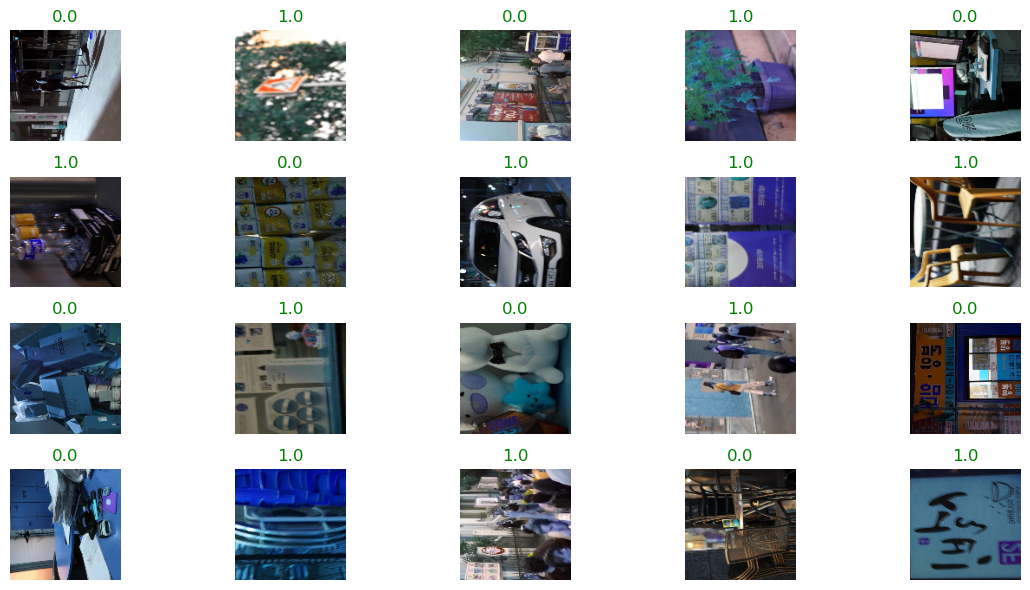

In [14]:
from utils import imshow

samples = next(iter(train_data))
imshow(samples)

We will use `ResNet` model as a baseline because it's a good choice for image classificaiton problems (i.e. our config states for `resnet152`):


In [15]:
model = getattr(models, config.model.baseline)(weights=config.model.weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

We also need to make a modification of the last (fully connected + sigmoid) layer of our network model since we have only a particular number of output classes):

In [16]:
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1),
    nn.Sigmoid(),
)

We also use Binary Cross Entropy loss as our lost function, Adam optimizer and a step learning rate scheduler that will decrease a learning rate after some step (defined in a config file)):

In [19]:
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.model.learning_rate, momentum=0.3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-5)

Main cell that goes through 10 epochs of training process using a CUDA device

In [20]:
train(model, train_data, val_data, config.model.num_epochs, loss_func, optimizer, scheduler)
print("Training Finished")

The model will be running on cuda:0 device


100%|██████████| 94/94 [00:20<00:00,  4.55it/s]


Epoch: 1    F1 Score: 0.5474359393119812


100%|██████████| 94/94 [00:20<00:00,  4.65it/s]


Epoch: 2    F1 Score: 0.49872469902038574


100%|██████████| 94/94 [00:20<00:00,  4.64it/s]


Epoch: 3    F1 Score: 0.660473108291626


100%|██████████| 94/94 [00:20<00:00,  4.64it/s]


Epoch: 4    F1 Score: 0.6723932027816772


100%|██████████| 94/94 [00:20<00:00,  4.63it/s]


Epoch: 5    F1 Score: 0.83868807554245


100%|██████████| 94/94 [00:20<00:00,  4.65it/s]


Epoch: 6    F1 Score: 0.757866382598877


100%|██████████| 94/94 [00:20<00:00,  4.63it/s]


Epoch: 7    F1 Score: 0.8308073282241821


100%|██████████| 94/94 [00:20<00:00,  4.67it/s]


Epoch: 8    F1 Score: 0.8915260434150696


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 9    F1 Score: 0.8912895321846008


100%|██████████| 94/94 [00:20<00:00,  4.69it/s]


Epoch: 10    F1 Score: 0.9119473695755005


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 11    F1 Score: 0.8710129857063293


100%|██████████| 94/94 [00:20<00:00,  4.67it/s]


Epoch: 12    F1 Score: 0.8792747855186462


100%|██████████| 94/94 [00:20<00:00,  4.67it/s]


Epoch: 13    F1 Score: 0.9318233728408813


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 14    F1 Score: 0.8828450441360474


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 15    F1 Score: 0.8823282122612


100%|██████████| 94/94 [00:20<00:00,  4.65it/s]


Epoch: 16    F1 Score: 0.9326345324516296


100%|██████████| 94/94 [00:20<00:00,  4.65it/s]


Epoch: 17    F1 Score: 0.9453253149986267


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 18    F1 Score: 0.9337725639343262


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 19    F1 Score: 0.9490476846694946


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 20    F1 Score: 0.9499489068984985


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 21    F1 Score: 0.9236752390861511


100%|██████████| 94/94 [00:20<00:00,  4.66it/s]


Epoch: 22    F1 Score: 0.6462862491607666


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 23    F1 Score: 0.8979893922805786


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 24    F1 Score: 0.9288226962089539


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 25    F1 Score: 0.9442445039749146


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 26    F1 Score: 0.9426361918449402


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 27    F1 Score: 0.9421332478523254


100%|██████████| 94/94 [00:20<00:00,  4.68it/s]


Epoch: 28    F1 Score: 0.9467844367027283


 74%|███████▍  | 70/94 [00:15<00:05,  4.61it/s]

After training, we get `` F1-score on a validation set, but of course we still need some testing.

P.S. We use F1-score to measure our model's performance since it's a best choice for imbalanced datasets. 

In [ ]:
model = getattr(models, config.model.baseline)(weights=config.model.weights)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid(),
)
model.load_state_dict(torch.load("./model.pth"))
model.eval()
filenames, predictions = test(model, test_data)

In [ ]:
test_df = pd.DataFrame({
    "filename": filenames, 
    "blur": [float(x) for x in predictions],
})
test_df.head()

,filename,blur
0,bnxzvzqlzlnnbxfkcuin.jpg,0.0
1,powqsnpoynygwqsciedp.jpg,1.0
2,zpjlbfhurhygjnqccpii.jpg,0.0
3,klqqjqnnvyeemvkavivp.jpg,0.0
4,qwhvkcwctjllkdxaycvj.jpg,0.0


In [ ]:
test_df.to_csv(os.path.join(config.data.path, 'submission.csv'), index=False)

Now the submission file needs to be uploaded. 

Thank you!